In [ ]:
# ==============================
# ==============================
# PART A
3. Model with ambient temperature
4. Residual analysis & comparison
5. Stand-alone predictor (Part A)

PART B
6. Model with ambient + supply temperature
7. Residual analysis & comparison
8. Stand-alone predictor (Part B)

PART C
9. Recursive estimation (Kalman filter)
10. Parameter evolution & prediction quality
11. Stand-alone predictor (Part C)

(OPTIONAL)
12. Automatic predictor comparison


**A — Output model using ambient temperature as external input**

- Identify stable modelling period (6–10 weeks).

- Validation set directly after modelling set.

- Test set: one week immediately after validation + one week from a different season.

- Build model, check residual whiteness, compare with naïve predictor.

- Produce stand-alone predictor function for Part A.

**B — Extended model using both ambient & supply water temperature**

- Re-estimate the model to include the second external input.

- Check residuals again, whiteness, comparison with naïve models.

- Produce stand-alone predictor function for Part B.

**C — Recursive estimation with Kalman filter**

- Recursively estimate parameters of model from Part B.

- Evaluate parameter evolution + recursive prediction quality.

- Check whether some parameters can be dropped.

- Produce stand-alone predictor function for Part C.

**D (Optional) — Automatic predictors**

- Prophet, NeuralProphet, TimeGPT, etc.

- Compare fairly (only modelling data allowed).

In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

# ==============================
# 1. Load and inspect data
# ==============================
mat = loadmat("../data/projectData25.mat")
data = mat["data"]          # 5000 x 8 array

print(data.shape)           # should be (5000, 8)

# Put into a DataFrame
cols = ["obs", "power", "temp_ambient", "temp_supply",
        "year", "month", "day", "hour"]
df = pd.DataFrame(data, columns=cols)

df.head()


(5000, 8)


,obs,power,temp_ambient,temp_supply,year,month,day,hour
0,89.0,47.26,26.09,73.86,1989.0,7.0,6.0,17.0
1,90.0,46.77,25.86,73.23,1989.0,7.0,6.0,18.0
2,91.0,49.70,26.09,74.18,1989.0,7.0,6.0,19.0
3,92.0,52.06,25.66,74.70,1989.0,7.0,6.0,20.0
4,93.0,50.88,25.19,74.86,1989.0,7.0,6.0,21.0


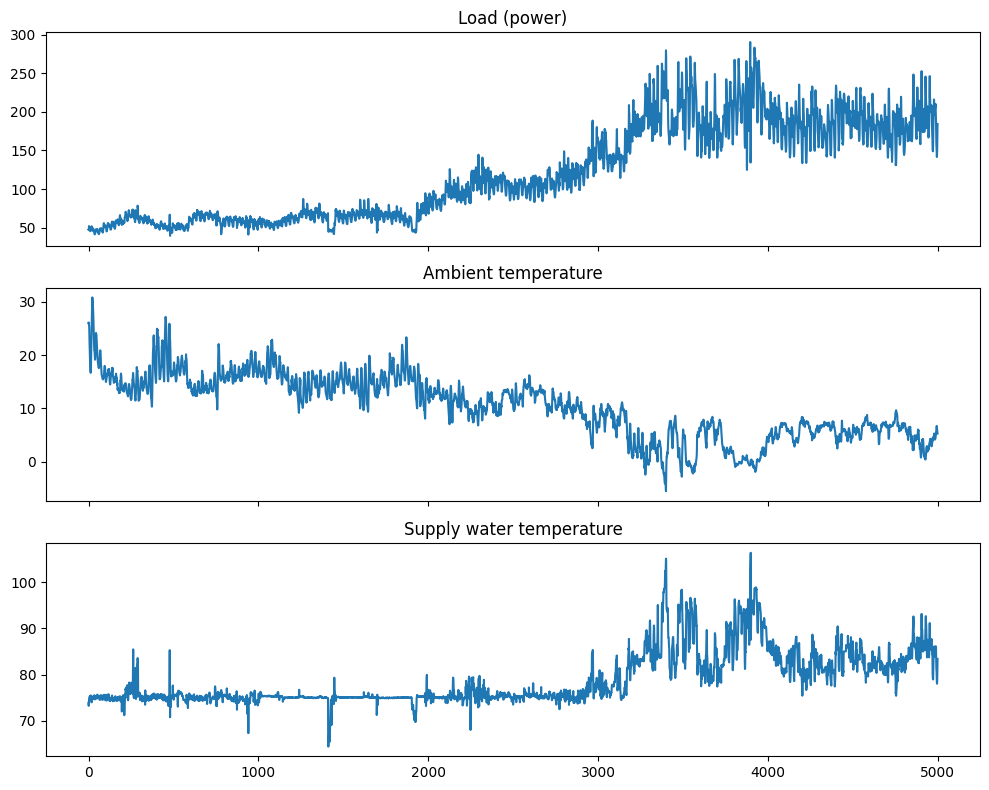

In [5]:
y  = df["power"].to_numpy()          # output
u1 = df["temp_ambient"].to_numpy()   # input 1
u2 = df["temp_supply"].to_numpy()    # input 2

#quick sanity check
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(y);  axs[0].set_title("Load (power)")
axs[1].plot(u1); axs[1].set_title("Ambient temperature")
axs[2].plot(u2); axs[2].set_title("Supply water temperature")
plt.tight_layout()
plt.show()

Power shape: (5000,)
Air temp shape: (5000,)
Supply temp shape: (5000,)


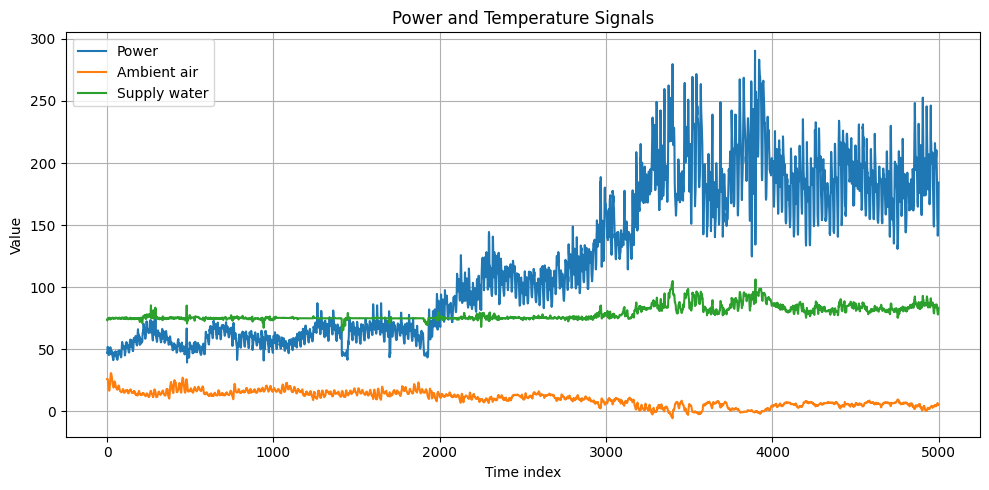

In [12]:
print("Power shape:", power.shape)
print("Air temp shape:", temp_air.shape)
print("Supply temp shape:", temp_supply.shape)

plt.figure(figsize=(10, 5))

plt.plot(power, label="Power")
plt.plot(temp_air, label="Ambient air")
plt.plot(temp_supply, label="Supply water")

plt.xlabel("Time index")
plt.ylabel("Value")
plt.title("Power and Temperature Signals")
plt.legend()
plt.tight_layout()
plt.show()

### Data partitioning 

- 6–10 weeks → modelling set

- Following weeks → validation

- One week after → test set 1

- One week in another season → test set 2

In [14]:
# Assuming hourly data → 24 samples per day
samples_per_week = 24 * 7

model_weeks = 8
val_weeks = 2
test_weeks = 1

N_model = model_weeks * samples_per_week
N_val = val_weeks * samples_per_week
N_test = test_weeks * samples_per_week

idx_model = np.arange(0, N_model)
idx_val = np.arange(N_model, N_model + N_val)
idx_test1 = np.arange(N_model + N_val, N_model + N_val + N_test)

# Second test set (later in data)
idx_test2 = np.arange(-N_test, 0)

print("Model samples:", len(idx_model))
print("Validation samples:", len(idx_val))
print("Test set 1 samples:", len(idx_test1))
print("Test set 2 samples:", len(idx_test2))

Model samples: 1344
Validation samples: 336
Test set 1 samples: 168
Test set 2 samples: 168


### PART A — Model with ambient air temperature only

1- Model load (power) using ambient air temperature as external input

2- Use only modelling data to estimate parameters

3- Evaluate:

One-step predictions

Residual whiteness

Compare with a naive predictor

4- Check k-step predictions (we’ll do k = 7)

5- Create a stand-alone predictor (later)

In [15]:
y = power
u = temp_air

y_model = y[idx_model]
u_model = u[idx_model]

y_val = y[idx_val]
u_val = u[idx_val]

Choose a simple ARX model

We will start with the simplest reasonable model:
y(t)= a1y (t−1)+b1u (t−1) + e(t)

This is perfectly acceptable for Part A.

Estimate ARX parameters (least squares)

In [16]:
# ==============================
# PART A – ARX(1,1) estimation
# ==============================

# Build regression matrix
Phi = np.column_stack([
    y_model[:-1],     # y(t-1)
    u_model[:-1]      # u(t-1)
])

y_target = y_model[1:]  # y(t)

# Least squares estimation
theta, *_ = np.linalg.lstsq(Phi, y_target, rcond=None)

a1, b1 = theta

print("Estimated parameters:")
print("a1 =", a1)
print("b1 =", b1)


Estimated parameters:
a1 = 0.996146815260961
b1 = 0.012270260838967692


One-step prediction on validation data

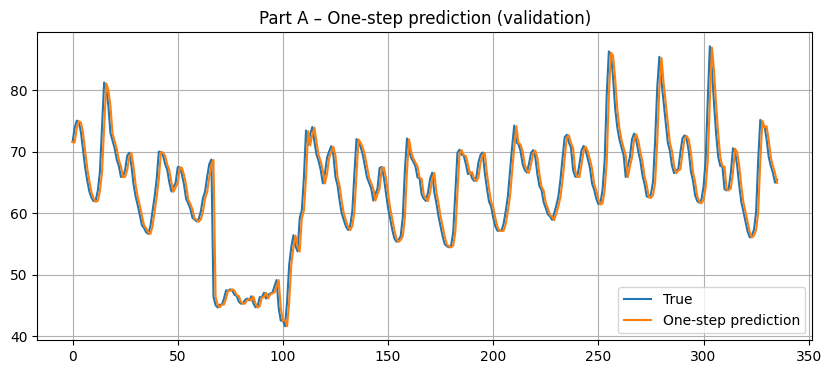

In [18]:
yhat_val = np.zeros_like(y_val)

# Initialize with true value
yhat_val[0] = y_val[0]

for t in range(1, len(y_val)):
    yhat_val[t] = a1 * y_val[t-1] + b1 * u_val[t-1]

plt.plot(y_val, label="True")
plt.plot(yhat_val, label="One-step prediction")
plt.legend()
plt.title("Part A – One-step prediction (validation)")
plt.show()


Residuals & whiteness check

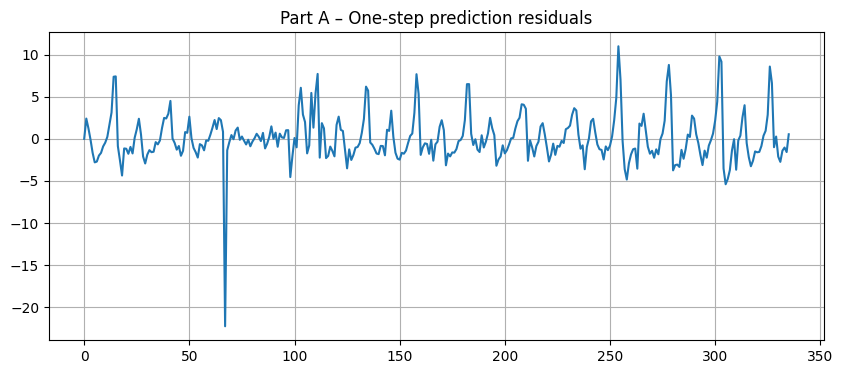

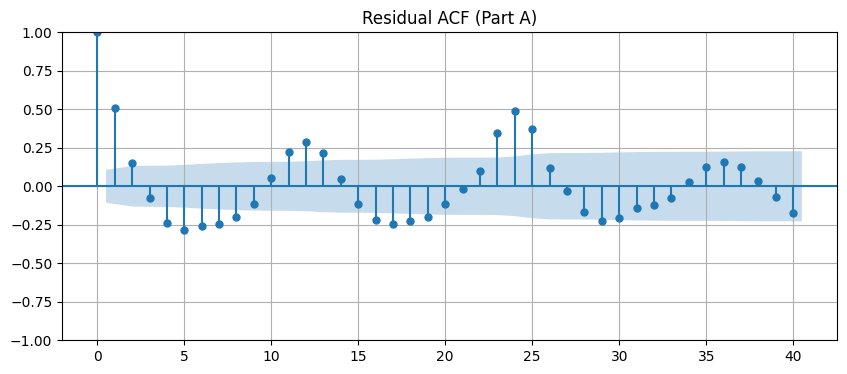

In [19]:
# Residuals & whiteness check

res_val = y_val - yhat_val
plt.plot(res_val)
plt.title("Part A – One-step prediction residuals")
plt.show()

# ACF
plot_acf(res_val, lags=40)
plt.title("Residual ACF (Part A)")
plt.show()

Compare with naive predictor

Naive predictor:
y^(t∣t−1)=y(t−1)

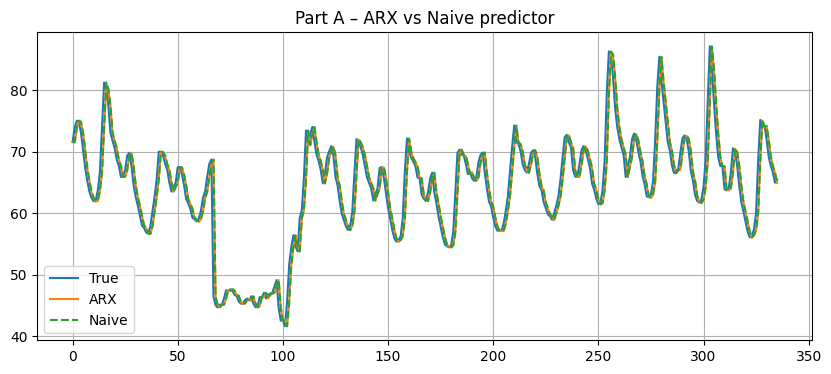

In [20]:
yhat_naive = np.roll(y_val, 1)
yhat_naive[0] = y_val[0]

plt.plot(y_val, label="True")
plt.plot(yhat_val, label="ARX")
plt.plot(yhat_naive, label="Naive", linestyle="--")
plt.legend()
plt.title("Part A – ARX vs Naive predictor")
plt.show()


Compute variances (also explicitly required):

In [21]:
var_arx = np.var(res_val)
var_naive = np.var(y_val - yhat_naive)

print("Residual variance (ARX):", var_arx)
print("Residual variance (Naive):", var_naive)
print("Normalized variance:", var_arx / var_naive)

Residual variance (ARX): 8.07623343522653
Residual variance (Naive): 8.084146811224489
Normalized variance: 0.999021124160317
